In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import csv
import random
from matplotlib import pyplot as plt
import math
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import seaborn as sns 
from scipy.stats import pearsonr# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
# Import BDB 2023 Data
# Pass plays week 1-8 season 2021

games_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/games.csv')
players_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/players.csv')
plays_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/plays.csv')
pff_df = pd.read_csv('../input/nfl-big-data-bowl-2023/pffScoutingData.csv')
weeks = []
for i in [1,2,3,4]:
    filename = '../input/nfl-big-data-bowl-2023/week'+str(i)+'.csv'
    weeks.append(pd.read_csv(filename))
weeks_df = pd.concat(weeks)

# merge scout data onto the tracking data 
weeks_df = weeks_df.merge(pff_df[['gameId', 'playId', 'nflId', 'pff_role','pff_positionLinedUp']], how='left')

# Import team color data from Lee Sharpe

teamcolors = pd.read_csv("https://raw.githubusercontent.com/leesharpe/nfldata/master/data/teamcolors.csv")

In [3]:
# get all plays that resulted in a sack or QB pass
_event = ['autoevent_passforward', 'pass_forward', 'qb_sack','qb_strip_sack']
_event_df = weeks_df.loc[weeks_df['event'].isin(_event)]
_gpf = _event_df.groupby(['gameId','playId','frameId']).size().reset_index().drop(columns=[0])
__gpf = _gpf.drop_duplicates(subset=['gameId','playId'], keep='first')
___gpf = __gpf.rename(columns={'frameId':'event_frame'})
___gpf = ___gpf.merge(plays_df[['gameId','playId','dropBackType']], how='left')
gpf = ___gpf.loc[___gpf['dropBackType']=='TRADITIONAL']

In [4]:
def data_prep(one_frame,next_frame):
    meta_cols = ['gameId', 'playId', 'nflId', 'frameId']
    data_cols = ['x', 'y', 's', 'dir', 'dis', 'a','pff_role']
    next_cols = ['x', 'y', 's', 'dir', 'a']
    meta_info = one_frame[meta_cols]
    play_dir = -2*int((one_frame.iloc[0].playDirection == 'left'))+1
    QB = one_frame.loc[one_frame['pff_role']=='Pass'][data_cols]
    no_QB = one_frame.loc[one_frame['pff_role']!='Pass'][data_cols]
    nfr = next_frame.loc[next_frame['pff_role']!='Pass'][next_cols].values
    no_QB['pff_role'] = (no_QB['pff_role'] == 'Pass Block').astype(int)
    no_QB_arr = no_QB.values
    xv = np.sin(no_QB_arr[:,3]*np.pi/180)*no_QB_arr[:,2]
    yv = np.cos(no_QB_arr[:,3]*np.pi/180)*no_QB_arr[:,2]
    no_QB_arr[:,[2,3]] = np.vstack((xv,yv)).T
    feat_list =[]
    for targ in no_QB_arr:
        t_arr = no_QB_arr.copy()
        t_arr[:,:2] = t_arr[:,:2] - targ[:2]
        dists = (t_arr[:,0]**2 + t_arr[:,1]**2)**0.5
        st_arr = t_arr[dists.argsort()[1:6]]
        st_arr[:,:4] = play_dir*st_arr[:,:4]
        indiv_feats = (QB[['x','y']].values[0] - targ[:2]).tolist()+targ[2:].tolist()
        feats = indiv_feats + np.concatenate(st_arr).tolist()
        feat_list.append(feats)
    n_xv = play_dir*(np.sin(nfr[:,3]*np.pi/180)*nfr[:,2])
    n_yv = play_dir*(np.cos(nfr[:,3]*np.pi/180)*nfr[:,2])
    nfr[:,[2,3]] = np.vstack((n_xv,n_yv)).T
    nfr[:,:2] = play_dir*(nfr[:,:2] - no_QB_arr[:,:2])
    target_list_o = nfr[no_QB.pff_role.values == 1].tolist()
    target_list_d = nfr[no_QB.pff_role.values == 0].tolist()
    feat_list_o = np.array(feat_list)[no_QB['pff_role'].values == 1].tolist()
    feat_list_d = np.array(feat_list)[no_QB['pff_role'].values == 0].tolist()
    
    return feat_list_o,feat_list_d,target_list_o,target_list_d

In [5]:
feats_o = []
feats_d = []
target_o = []
target_d = []
in_cols = ['gameId', 'playId', 'nflId', 'frameId','playDirection','x', 'y', 's', 'a', 'dis', 'dir','pff_role']
for i, data in tqdm(gpf.iterrows()):
    one_play = weeks_df.loc[(weeks_df['gameId']==data.gameId)&(weeks_df['playId']==data.playId)]
    one_play['sec_til_event'] = (data.event_frame - one_play.frameId)/10
    snap_fr = one_play.loc[one_play['event'].isin(['autoevent_ballsnap', 'ball_snap'])].frameId.max()
    play_players = one_play.loc[(one_play['frameId'] >= snap_fr - 1) &
                                (one_play['pff_role'].isin(['Pass','Pass Rush','Pass Block'])) &
                                (one_play['sec_til_event'] >= 0)]
    
    if not sorted(play_players.pff_role.unique()) == sorted(['Pass','Pass Rush','Pass Block']):
            continue 
    
    for fid in play_players.frameId.unique()[:-1]:
        one_frame = play_players.loc[play_players['frameId']==fid][in_cols]
        next_frame = play_players.loc[play_players['frameId']==fid+1][in_cols]
        f_list_o, f_list_d, t_list_o, t_list_d = data_prep(one_frame,next_frame)
        feats_o = feats_o + f_list_o
        feats_d = feats_d + f_list_d
        target_o = target_o + t_list_o
        target_d = target_d + t_list_d

0it [00:00, ?it/s]

In [6]:
def build_model(feats,target,name):
    X_train, X_valid, y_train, y_valid = train_test_split(np.array(feats),
                                                          np.array(target), 
                                                          train_size=0.8, 
                                                          test_size=0.2,
                                                          random_state=2) 
    model = keras.Sequential([
        layers.Dense(50, activation='relu', input_shape=(42,)),
        layers.Dense(25, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(5),
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        loss_weights=np.array([10,10,5,5,3])
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=200,
        epochs=250,
        verbose=2,
        )

    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot();
    print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

    model.save(name+".h5")
    return model

2022-12-14 00:32:37.360006: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-14 00:32:37.832145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250
1664/1664 - 7s - loss: 1.9428 - val_loss: 0.6036
Epoch 2/250
1664/1664 - 5s - loss: 0.5387 - val_loss: 0.4935
Epoch 3/250
1664/1664 - 4s - loss: 0.4642 - val_loss: 0.4475
Epoch 4/250
1664/1664 - 4s - loss: 0.4260 - val_loss: 0.4221
Epoch 5/250
1664/1664 - 4s - loss: 0.4017 - val_loss: 0.4001
Epoch 6/250
1664/1664 - 4s - loss: 0.3811 - val_loss: 0.4048
Epoch 7/250
1664/1664 - 4s - loss: 0.3658 - val_loss: 0.3634
Epoch 8/250
1664/1664 - 4s - loss: 0.3537 - val_loss: 0.3609
Epoch 9/250
1664/1664 - 5s - loss: 0.3443 - val_loss: 0.3448
Epoch 10/250
1664/1664 - 4s - loss: 0.3372 - val_loss: 0.3833
Epoch 11/250
1664/1664 - 4s - loss: 0.3309 - val_loss: 0.3384
Epoch 12/250
1664/1664 - 4s - loss: 0.3249 - val_loss: 0.3436
Epoch 13/250
1664/1664 - 4s - loss: 0.3215 - val_loss: 0.3358
Epoch 14/250
1664/1664 - 4s - loss: 0.3172 - val_loss: 0.3329
Epoch 15/250
1664/1664 - 4s - loss: 0.3137 - val_loss: 0.3321
Epoch 16/250
1664/1664 - 5s - loss: 0.3109 - val_loss: 0.3271
Epoch 17/250
1664

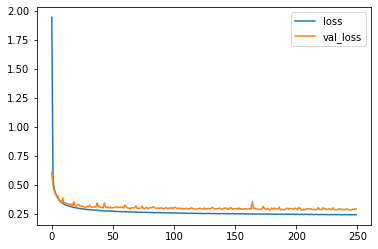

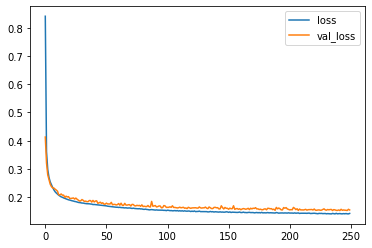

In [7]:
def_model = build_model(feats_d,target_d,'model_DL_movement')
off_model = build_model(feats_o,target_o,'model_OL_movement')